# Library

In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/apple-data')

Skipping, found downloaded files in "./apple-data" (use force=True to force download)


In [2]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [3]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Mon May 15 05:55:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    375MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Modelling Without Augmentation

## DenseNet Model 1

In [6]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DenseNet_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [7]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [8]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.9198
Epoch 1: val_accuracy improved from -inf to 0.95265, saving model to Apple_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 130s 284ms/step - loss: 0.3441 - accuracy: 0.9198 - val_loss: 0.1813 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9699
Epoch 2: val_accuracy improved from 0.95265 to 0.98353, saving model to Apple_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 105s 262ms/step - loss: 0.0933 - accuracy: 0.9699 - val_loss: 0.0616 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9772
Epoch 3: val_accuracy improved from 0.98353 to 0.98971, saving model to Apple_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 105s 261ms/step - loss: 0.0751 - accuracy: 0.9772 - val_loss: 0.0315 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9787
Epoch 4: val_accuracy did not improve from 0.98971
401/401 [==============================] - 71s 176ms/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.1063 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9809
Epoch 5: val_accuracy did not improve from 0.98971
401/401 [==============================] - 72s 180ms/step - loss: 0.0593 - accuracy: 0.9809 - val_loss: 0.2468 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9845
Epoch 6: val_accuracy improved from 0.98971 to 0.99074, saving model to Apple_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 109s 271ms/step - loss: 0.0442 - accuracy: 0.9845 - val_loss: 0.0298 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9871
Epoch 7: val_accuracy did not improve from 0.99074
401/401 [==============================] - 71s 177ms/step - loss: 0.0442 - accuracy: 0.9871 - val_loss: 0.0964 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9808
Epoch 8: val_accuracy did not improve from 0.99074
401/401 [==============================] - 72s 180ms/step - loss: 0.0621 - accuracy: 0.9808 - val_loss: 0.0977 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9879
Epoch 9: val_accuracy did not improve from 0.99074
401/401 [==============================] - 73s 182ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0316 - v

INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 107s 268ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.0267 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9848
Epoch 12: val_accuracy did not improve from 0.99125
401/401 [==============================] - 72s 178ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.6546 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9860
Epoch 13: val_accuracy did not improve from 0.99125
401/401 [==============================] - 73s 181ms/step - loss: 0.0420 - accuracy: 0.9860 - val_loss: 0.0389 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9896
Epoch 14: val_accuracy improved from 0.99125 to 0.99382, saving model to Apple_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 111s 276ms/step - loss: 0.0297 - accuracy: 0.9896 - val_loss: 0.0270 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9844
Epoch 15: val_accuracy did not improve from 0.99382
401/401 [==============================] - 75s 188ms/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0718 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9889
Epoch 16: val_accuracy did not improve from 0.99382

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
401/401 [==============================] - 77s 191ms/step - loss: 0.0312 - accuracy: 0.9889 - val_loss: 0.6733 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9941
Epoch 17: val_accuracy improved from 0.99382 to 0.99949, saving model to Apple_De

INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Non_Augmented\assets


401/401 [==============================] - 112s 281ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0020 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9966
Epoch 18: val_accuracy did not improve from 0.99949
401/401 [==============================] - 75s 187ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0016 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9986
Epoch 19: val_accuracy did not improve from 0.99949
401/401 [==============================] - 73s 182ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0022 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9984
Epoch 20: val_accuracy did not improve from 0.99949
401/401 [==============================] - 72s 179ms/step - loss: 0.0052 - accuracy: 0.9984 - va

Text(0.5, 1.0, 'Training and validation loss DIY Model')

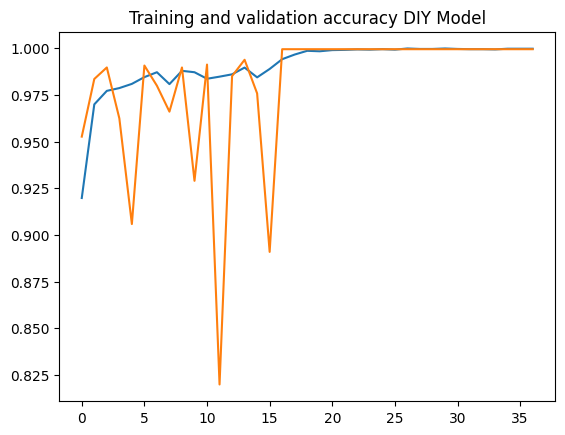

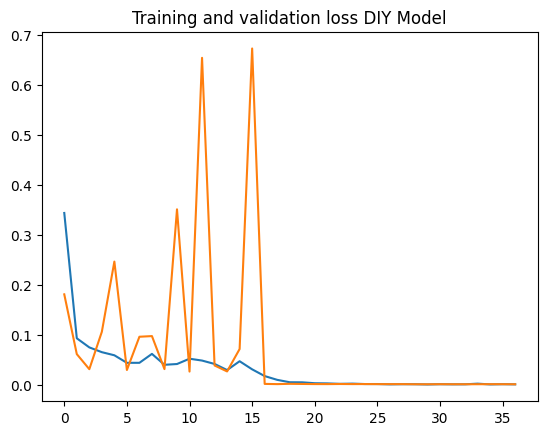

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

## DenseNet Model 2

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DenseNet_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9395
Epoch 1: val_accuracy improved from -inf to 0.83788, saving model to Apple_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 119s 275ms/step - loss: 0.1913 - accuracy: 0.9395 - val_loss: 0.5744 - val_accuracy: 0.8379 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9706
Epoch 2: val_accuracy did not improve from 0.83788
401/401 [==============================] - 72s 179ms/step - loss: 0.0892 - accuracy: 0.9706 - val_loss: 1.5024 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9697
Epoch 3: val_accuracy improved from 0.83788 to 0.99588, saving model to Apple_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 109s 272ms/step - loss: 0.0930 - accuracy: 0.9697 - val_loss: 0.0159 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9804
Epoch 4: val_accuracy did not improve from 0.99588
401/401 [==============================] - 73s 180ms/step - loss: 0.0559 - accuracy: 0.9804 - val_loss: 0.0911 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9795
Epoch 5: val_accuracy did not improve from 0.99588
401/401 [==============================] - 73s 181ms/step - loss: 0.0580 - accuracy: 0.9795 - val_loss: 0.3348 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9853
Epoch 6: val_accuracy did not improve from 0.99588
401/401 [==============================] - 73s 181ms/step - loss: 0.0398 - accuracy: 0.9853 - val_loss: 0.0865 - v

INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 109s 273ms/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0064 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9950
Epoch 10: val_accuracy improved from 0.99794 to 0.99846, saving model to Apple_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 108s 269ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0055 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9968
Epoch 11: val_accuracy did not improve from 0.99846
401/401 [==============================] - 72s 178ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0036 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9970
Epoch 12: val_accuracy did not improve from 0.99846
401/401 [==============================] - 76s 189ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0035 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9979
Epoch 13: val_accuracy improved from 0.99846 to 0.99897, saving model to Apple_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 115s 286ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0023 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986
Epoch 14: val_accuracy did not improve from 0.99897
401/401 [==============================] - 78s 195ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0039 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9978
Epoch 15: val_accuracy did not improve from 0.99897
401/401 [==============================] - 75s 186ms/step - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.0033 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9981
Epoch 16: val_accuracy improved from 0.99897 to 0.99949, saving model to Apple_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Non_Augmented\assets


401/401 [==============================] - 114s 283ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.0027 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9994
Epoch 17: val_accuracy did not improve from 0.99949
401/401 [==============================] - 74s 185ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995
Epoch 18: val_accuracy did not improve from 0.99949

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
401/401 [==============================] - 76s 189ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0038 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 19: val_accuracy did not improve from 0.99949
401/401 [========

Text(0.5, 1.0, 'Training and validation loss DIY Model')

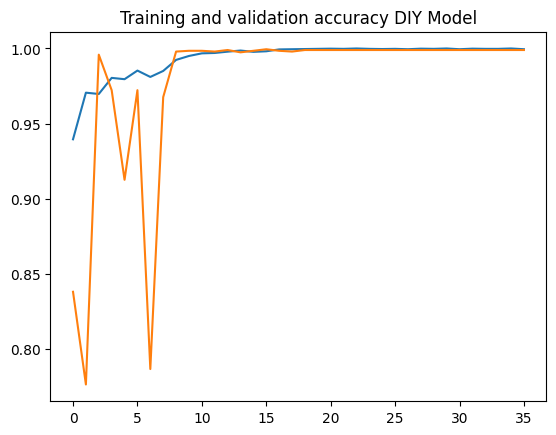

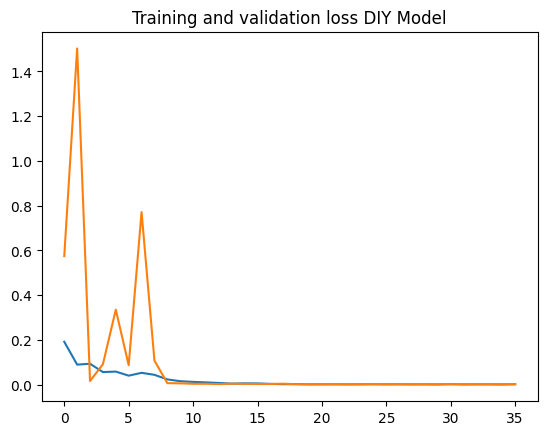

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')